# Initialization

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Enable/disable test mode
test_mode = True

## Import and visualize the dataset

In [4]:
# Set the path to the dataset
dataset = pd.read_csv('../input/homework2/Training.csv')
#dataset = pd.read_csv('../input/Training.csv')
print(dataset.shape) 
dataset.head().transpose()

(68528, 7)


,0,1,2,3,4
Sponginess,7.97698,8.078240,8.02844,8.028440,7.875720
Wonder level,4.33494,4.446160,4.22372,4.223720,4.446160
Crunchiness,10.67282,10.561600,10.56160,10.561600,10.450380
Loudness on impact,1.76692,1.707160,1.64906,1.707160,1.707160
Meme creativity,3.22440,3.325660,3.17460,3.174600,3.275860
Soap slipperiness,51.68146,51.563598,50.86308,45.841581,47.126421
Hype root,3.65434,3.476720,3.47672,3.476720,3.476720


In [5]:
dataset.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


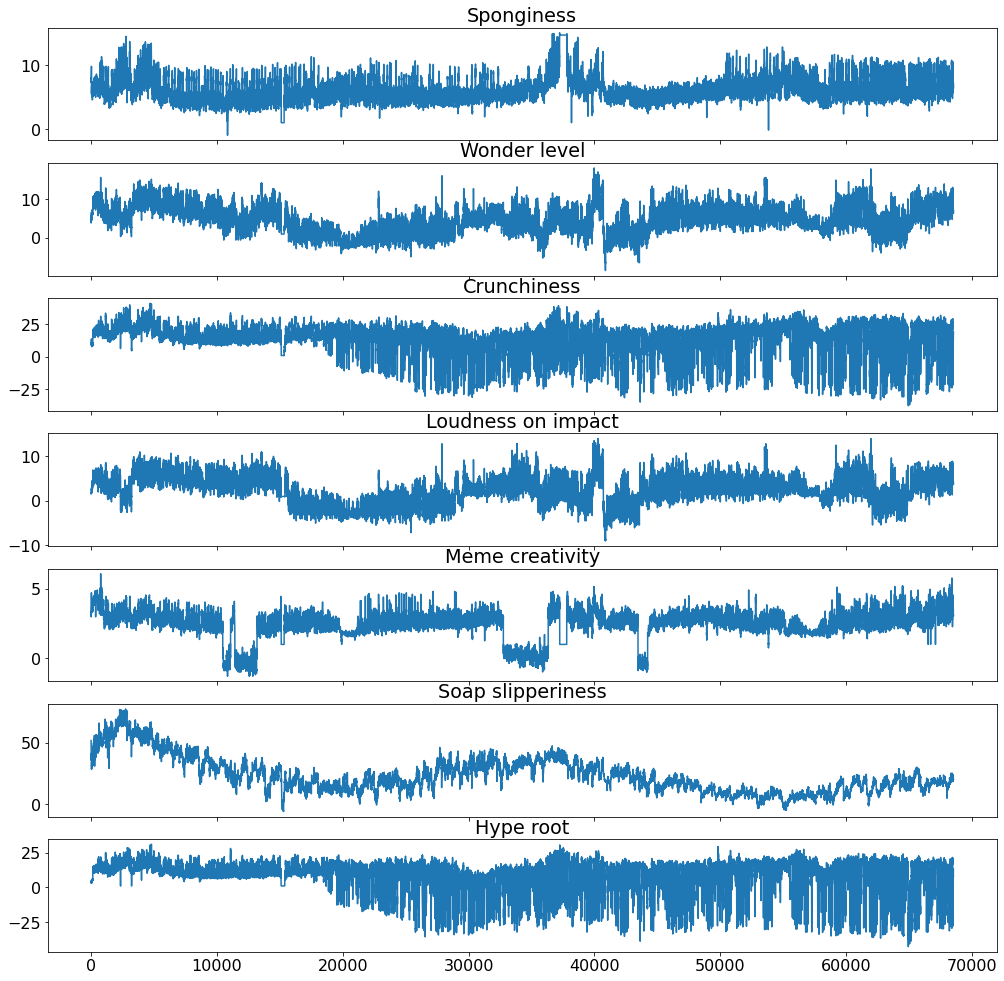

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

# Data preprocessing

In [8]:
if(test_mode):
    test_size = 10000
    X_train_raw = dataset.iloc[:-test_size]
    X_test_raw = dataset.iloc[-test_size:]
else:
    X_train_raw = dataset

# y_train_raw = y.iloc[:-test_size]
# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

if(test_mode):
    # y_test_raw = y.iloc[-test_size:]
    X_test_raw = (X_test_raw-X_min)/(X_max-X_min)



## Extracting sequences from the dataset

In [9]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')#float32
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
target_labels = dataset.columns
window = 600
stride = 10
telescope = 864

In [11]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 600, 7)

In [12]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
print(X_train.shape, y_train.shape)

if(test_mode):
    X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
    print(X_test.shape, y_test.shape)

(5734, 600, 7) (5734, 864, 7)
(874, 600, 7) (874, 864, 7)


In [13]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

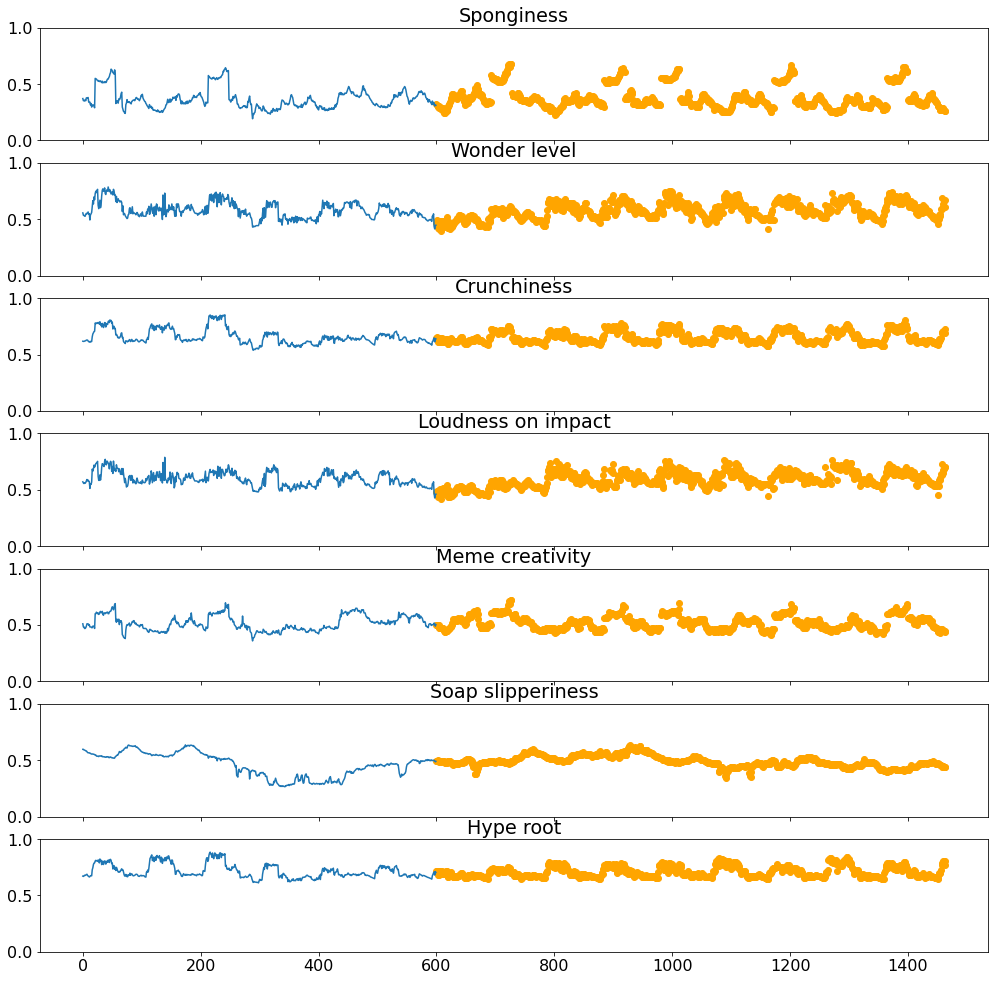

In [14]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

# Train the model

In [15]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print(y_train.shape)

batch_size = 128
epochs = 200

model_name = 'BiLSTM'

(5734, 864, 7)


In [16]:
def build_model(input_shape ,output_shape):
    #create model
    model = tfk.Sequential()
    model.add(tfkl.Bidirectional(tfkl.LSTM(units=256, return_sequences=True), input_shape=input_shape))
    model.add(tfkl.Dropout(0.2))

    model.add(tfkl.Bidirectional(tfkl.LSTM(units=256, return_sequences=True)))
    model.add(tfkl.Dropout(0.2))

    model.add(tfkl.Bidirectional(tfkl.LSTM(units=256)))
    model.add(tfkl.Dropout(0.2))

    model.add(tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu'))
    model.add(tfkl.Reshape(output_shape))
    model.add(tfkl.Conv1D(output_shape[-1], 1, padding='same'))

    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])


    return model


2021-12-28 10:33:04.344228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 10:33:04.434875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 10:33:04.435677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 10:33:04.436923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 600, 512)          540672    
_________________________________________________________________
dropout (Dropout)            (None, 600, 512)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 512)          1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 512)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6048)              3

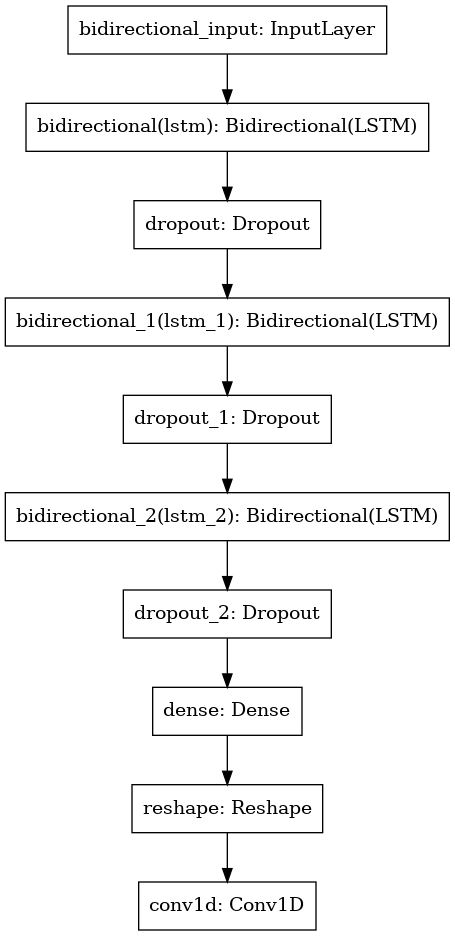

In [17]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [18]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2021-12-28 10:33:09.486250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-12-28 10:33:16.768069: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 36s 638ms/step - loss: 0.1537 - mae: 0.3207 - val_loss: 0.1334 - val_mae: 0.3020
Epoch 2/200
36/36 [==============================] - 21s 587ms/step - loss: 0.1023 - mae: 0.2495 - val_loss: 0.1028 - val_mae: 0.2605
Epoch 3/200
36/36 [==============================] - 21s 588ms/step - loss: 0.0774 - mae: 0.2115 - val_loss: 0.0805 - val_mae: 0.2276
Epoch 4/200
36/36 [==============================] - 21s 589ms/step - loss: 0.0591 - mae: 0.1809 - val_loss: 0.0644 - val_mae: 0.2088
Epoch 5/200
36/36 [==============================] - 21s 587ms/step - loss: 0.0470 - mae: 0.1616 - val_loss: 0.0531 - val_mae: 0.1870
Epoch 6/200
36/36 [==============================] - 21s 585ms/step - loss: 0.0393 - mae: 0.1500 - val_loss: 0.0461 - val_mae: 0.1788
Epoch 7/200
36/36 [==============================] - 21s 586ms/step - loss: 0.0337 - mae: 0.1410 - val_loss: 0.0405 - val_mae: 0.1668
Epoch 8/200
36/36 [==============================] - 21s 585ms/step - loss

In [19]:
exp_dir = ''
model.save(os.path.join(exp_dir, model_name))

2021-12-28 10:56:53.859920: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Analyze the results

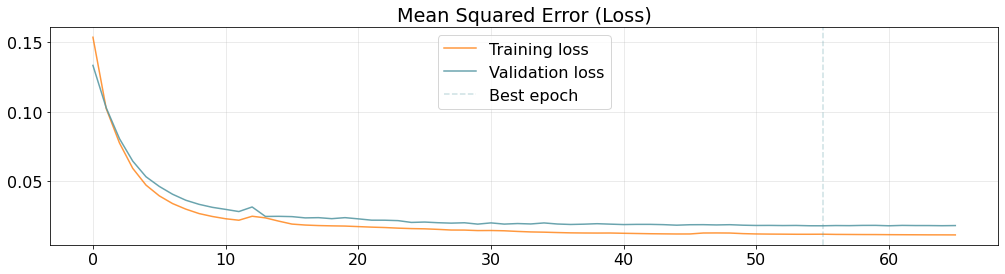

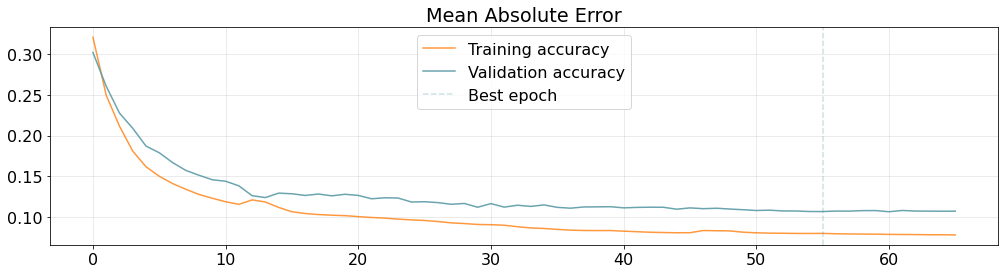

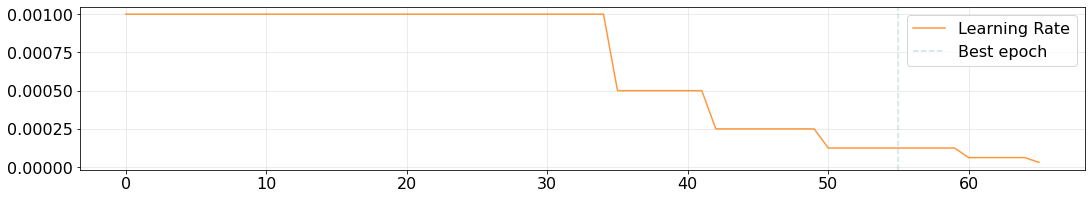

In [20]:
# Plot loss, accuracy and learning rate
best_epoch = np.argmin(history['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [21]:
# Predict the test set 
if(test_mode):
    predictions = model.predict(X_test)
    print(predictions.shape)

    mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
    mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
    print(mean_squared_error, mean_absolute_error)

(874, 864, 7)
tf.Tensor(0.018302578, shape=(), dtype=float32) tf.Tensor(0.10642177, shape=(), dtype=float32)


In [22]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

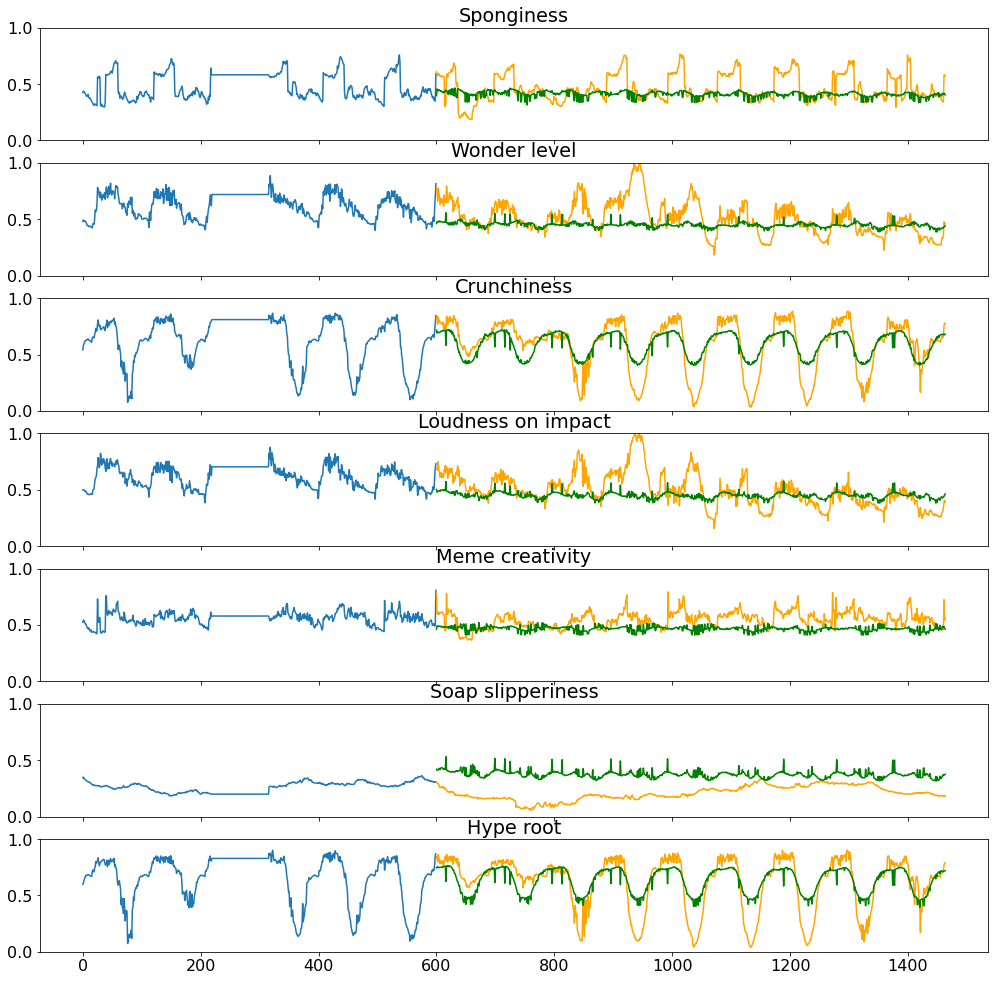

In [23]:
if(test_mode):
    inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [24]:
if(test_mode):
    maes = []
    for i in range(predictions.shape[1]):
        ft_maes = []
        for j in range(predictions.shape[2]):
            ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
        ft_maes = np.array(ft_maes)
        maes.append(ft_maes)
    maes = np.array(maes)

In [25]:
if(test_mode):
    future_predictions = model.predict(future)
    print(future_predictions.shape)

(1, 864, 7)


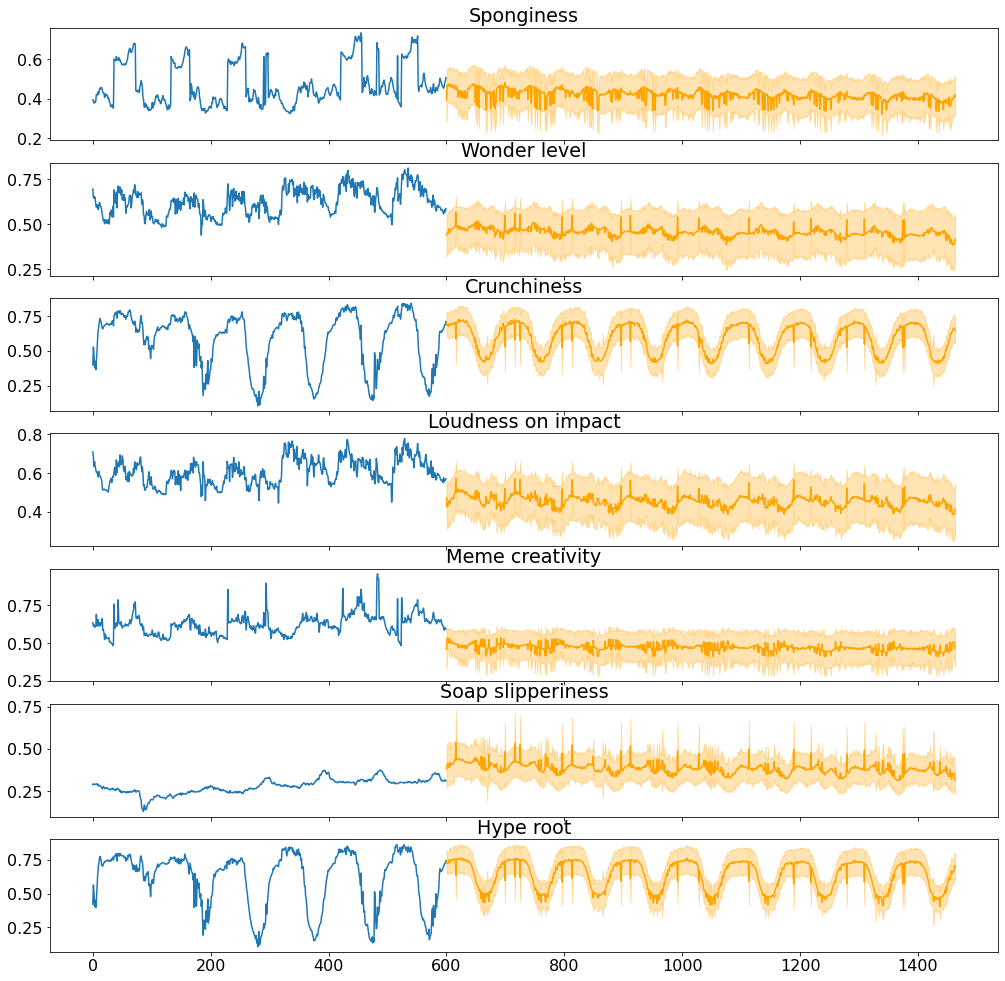

In [26]:
if(test_mode):
    figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(target_labels):
        axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
        axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
        axs[i].fill_between(
            np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
            future_predictions[0,:,i]+maes[:,i], 
            future_predictions[0,:,i]-maes[:,i], 
            color='orange', alpha=.3)
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()